# **Project 3: Loan Default Prediction**
# **Katie Fan**

### **Index:**
**1. Data Loading**

**2. Data Cleaning**

- 2.1. encode target vatiable to 0 and 1

- 2.2. check data format

- 2.3. check outliers
    
**3. Feature Selection**

- 3.1. remove id columns

- 3.2. remove future feature

- 3.3. remove features that have missing ratio > 10%

- 3.4. remove feature that are irrelevent or redundant 
- 3.5. remove statistically insignificant features by using Chi-Square test and Welch's t test

- 3.6. remove highly correlated features(multicolinearity)

**4. Feature Engineering**

**5. Under Sampling**

**6. Converting Categorical Features to Dummy Features**

**7. Training Test Sets Spliting**

**8. Standard Scaling and Missing Value Imputing**

In [1]:
# import libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy
import glob
import os
import csv
from datetime import datetime
import pickle
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA 

## **Data Loading**

In [2]:
# data is donwloaded from https://www.lendingclub.com/info/download-data.action
# total 16 files
file_path = r'/Users/katiefan/Documents/loan_data' 
all_csv_files = glob.glob(file_path + "/*.csv")
df_each = [pd.read_csv(file, low_memory=False, header=1) for file in all_csv_files]
df_all_raw = pd.concat(df_each, ignore_index=True)

In [3]:
df_all_raw.shape

(2260701, 145)

In [4]:
df_all_raw.head(2)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,10000.0,10000.0,10000.0,36 months,10.33%,324.23,B,B1,...,NaN,NaN,DirectPay,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,2500.0,2500.0,2500.0,36 months,13.56%,84.92,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


## **Data Cleaning**

### **1. encode target vatiable to 0 and 1**

In [5]:
df_all_raw.loan_status.value_counts()

Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: loan_status, dtype: int64

In [6]:
# create a function to restrict analysis on fully paid loans and default loans (default,  loans)
def get_status_bin(x):
    if x == 'Fully Paid':
        return 0
    elif (x == 'Late (16-30 days)') | (x == 'Late (31-120 days)') | (x == 'Charged Off') | (x =='Default'):
        return 1
    else:
        return 'not in scope'

In [7]:
df_all_raw['loan_status_bin'] = df_all_raw['loan_status'].apply(get_status_bin)

In [8]:
df_all_raw = df_all_raw.loc[df_all_raw['loan_status_bin'] != 'not in scope']

In [9]:
df_all_raw['loan_status_bin'].value_counts(normalize=True, dropna=False)

0    0.785281
1    0.214719
Name: loan_status_bin, dtype: float64

In [10]:
df_all_raw.loan_status_bin.value_counts()

0    1076751
1     294415
Name: loan_status_bin, dtype: int64

In [11]:
df_all_raw.drop('loan_status', axis=1, inplace=True)

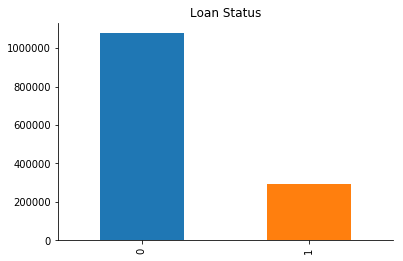

In [12]:
df_all_raw.loan_status_bin.value_counts().plot(kind='bar', title='Loan Status')
sns.despine();

### **2. check data format**

In [13]:
# convert interest rate and revol_util to numeric
df_all_raw['int_rate'] = df_all_raw['int_rate'].str.replace("%", "").str.replace(" ", "").astype(float)
df_all_raw['revol_util'] = df_all_raw['revol_util'].str.replace("%", "").astype(float)

### **3. check outliers**

In [14]:
df_all_raw.describe()

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,url,dti,delinq_2yrs,...,deferral_term,hardship_amount,hardship_length,hardship_dpd,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,settlement_amount,settlement_percentage,settlement_term
count,0.0,1.371166e+06,1.371166e+06,1.371166e+06,1.371166e+06,1.371166e+06,1.371166e+06,0.0,1.370763e+06,1.371166e+06,...,7631.0,7631.00000,7631.0,7631.000000,5451.000000,7631.000000,7631.000000,34198.000000,34198.000000,34198.000000
mean,NaN,1.446895e+04,1.446069e+04,1.443861e+04,1.328413e+01,4.392885e+02,7.626933e+04,NaN,1.831588e+01,3.187083e-01,...,3.0,153.45325,3.0,14.515005,441.783528,11373.131381,192.631862,5009.942763,47.766837,13.194924
std,NaN,8.744235e+03,8.740435e+03,8.742821e+03,4.790524e+00,2.621785e+02,7.026729e+04,NaN,1.132719e+01,8.801374e-01,...,0.0,131.54247,0.0,9.451345,378.787841,7629.284695,198.198606,3689.934458,7.299424,8.161496
min,NaN,5.000000e+02,5.000000e+02,0.000000e+00,5.310000e+00,4.930000e+00,0.000000e+00,NaN,-1.000000e+00,0.000000e+00,...,3.0,0.64000,3.0,0.000000,1.920000,55.730000,0.010000,44.210000,0.200000,0.000000
25%,NaN,8.000000e+03,8.000000e+03,7.950000e+03,9.750000e+00,2.491900e+02,4.576000e+04,NaN,1.180000e+01,0.000000e+00,...,3.0,55.83000,3.0,7.000000,161.460000,5277.805000,45.255000,2208.370000,45.000000,6.000000
50%,NaN,1.200000e+04,1.200000e+04,1.200000e+04,1.279000e+01,3.754900e+02,6.500000e+04,NaN,1.763000e+01,0.000000e+00,...,3.0,114.74000,3.0,16.000000,330.990000,9659.450000,130.660000,4147.000000,45.000000,14.000000
75%,NaN,2.000000e+04,2.000000e+04,2.000000e+04,1.602000e+01,5.821700e+02,9.000000e+04,NaN,2.409000e+01,0.000000e+00,...,3.0,213.62000,3.0,23.000000,603.975000,15965.080000,280.230000,6850.320000,50.000000,18.000000
max,NaN,4.000000e+04,4.000000e+04,4.000000e+04,3.099000e+01,1.719830e+03,1.099920e+07,NaN,9.990000e+02,3.900000e+01,...,3.0,943.94000,3.0,37.000000,2679.150000,39542.450000,1407.860000,33601.000000,521.350000,181.000000


In [15]:
df_all_raw = df_all_raw.loc[df_all_raw.dti>=0]
df_all_raw.shape

(1370761, 145)

In [16]:
print('mean:', df_all_raw.annual_inc.mean())
print('95% quantile:', df_all_raw.annual_inc.quantile(0.95))
print('99% quantile:', df_all_raw.annual_inc.quantile(0.99))
print('max:', df_all_raw.annual_inc.max())

mean: 76291.74148130925
95% quantile: 155000.0
99% quantile: 252000.0
max: 10999200.0


In [17]:
df_all_raw = df_all_raw.loc[df_all_raw.annual_inc <= df_all_raw.annual_inc.quantile(0.99)]
df_all_raw.shape

(1357093, 145)

In [18]:
# save csv
df_all_raw.to_csv('prj3_df_all_raw.csv')

In [19]:
# pickle the data
df_all_raw.to_pickle('prj3_df_raw.pkl')

In [39]:
df_all_raw = pd.read_pickle('prj3_df_raw.pkl')

## **Feature Selection**

### **1. remove unique ID columns**

In [20]:
# Removing unique ID cols as they seem irrelevent with the analysis
df_all = df_all_raw.drop(['id', 'member_id'], axis=1)
df_all.shape

(1357093, 143)

### **2. remove features that have more than 10% of data missing**

In [21]:
# Check missing values
all_data_na = (df_all.isnull().sum() / len(df_all)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing_Ratio':all_data_na}).reset_index().rename(columns={'index': 'Feature'})
missing_data.head()

,Feature,Missing_Ratio
0,url,100.000000
1,orig_projected_additional_accrued_interest,99.602459
2,sec_app_mths_since_last_major_derog,99.445506
3,hardship_loan_status,99.443664
4,hardship_start_date,99.443664


In [22]:
# Remove all the features that have more than 10% of data missing
missing_list = missing_data.Feature[missing_data.Missing_Ratio >= 10].tolist()
df_all.drop(missing_list, axis=1, inplace=True)
df_all.shape

(1357093, 86)

In [23]:
print(len(missing_list), 'features have more than 50% of values missing')
missing_list

57 features have more than 50% of values missing


['url',
 'orig_projected_additional_accrued_interest',
 'sec_app_mths_since_last_major_derog',
 'hardship_loan_status',
 'hardship_start_date',
 'hardship_end_date',
 'payment_plan_start_date',
 'hardship_length',
 'hardship_dpd',
 'hardship_amount',
 'hardship_status',
 'hardship_payoff_balance_amount',
 'hardship_last_payment_amount',
 'hardship_reason',
 'hardship_type',
 'deferral_term',
 'sec_app_revol_util',
 'revol_bal_joint',
 'sec_app_collections_12_mths_ex_med',
 'sec_app_chargeoff_within_12_mths',
 'sec_app_num_rev_accts',
 'sec_app_open_act_il',
 'sec_app_open_acc',
 'sec_app_mort_acc',
 'sec_app_inq_last_6mths',
 'sec_app_earliest_cr_line',
 'next_pymnt_d',
 'verification_status_joint',
 'dti_joint',
 'annual_inc_joint',
 'settlement_percentage',
 'settlement_term',
 'debt_settlement_flag_date',
 'settlement_status',
 'settlement_date',
 'settlement_amount',
 'desc',
 'mths_since_last_record',
 'mths_since_recent_bc_dlq',
 'mths_since_last_major_derog',
 'mths_since_recent

### **3. remove future features**

some features contain data about the loan’s future status which one doesn’t know about when allocating investments.

In [24]:
drop_list = ['issue_d','funded_amnt', 'funded_amnt_inv', 'initial_list_status','out_prncp','out_prncp_inv','total_pymnt','total_pymnt_inv','total_rec_prncp','total_rec_int','total_rec_late_fee','recoveries','collection_recovery_fee','last_pymnt_d','last_pymnt_amnt','collections_12_mths_ex_med','acc_now_delinq','tot_coll_amt','tot_cur_bal','acc_open_past_24mths','avg_cur_bal','chargeoff_within_12_mths','delinq_amnt','pct_tl_nvr_dlq','hardship_flag','debt_settlement_flag']
df_all.drop(drop_list, axis=1, inplace=True)
df_all.shape

(1357093, 60)

In [25]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1357093 entries, 52 to 2260695
Data columns (total 60 columns):
loan_amnt                     1357093 non-null float64
term                          1357093 non-null object
int_rate                      1357093 non-null float64
installment                   1357093 non-null float64
grade                         1357093 non-null object
sub_grade                     1357093 non-null object
emp_title                     1269506 non-null object
emp_length                    1276784 non-null object
home_ownership                1357093 non-null object
annual_inc                    1357093 non-null float64
verification_status           1357093 non-null object
pymnt_plan                    1357093 non-null object
purpose                       1357093 non-null object
title                         1340199 non-null object
zip_code                      1357092 non-null object
addr_state                    1357093 non-null object
dti               

### **4. remove features that are irrivelent or redundant**

In [26]:
drop_col =['mo_sin_old_rev_tl_op','mo_sin_rcnt_rev_tl_op','mo_sin_rcnt_tl','total_rev_hi_lim','mths_since_recent_bc','num_accts_ever_120_pd','num_actv_bc_tl','num_actv_rev_tl','num_bc_sats','num_bc_tl','num_il_tl','num_op_rev_tl','num_rev_accts','num_rev_tl_bal_gt_0','num_sats','num_tl_120dpd_2m','num_tl_30dpd','num_tl_90g_dpd_24m','num_tl_op_past_12m','percent_bc_gt_75','tax_liens','tot_hi_cred_lim','total_bal_ex_mort','sub_grade','emp_title','pymnt_plan','zip_code','title','last_credit_pull_d','disbursement_method']
df_all.drop(drop_col, axis=1, inplace=True)
df_all.shape

(1357093, 30)

In [27]:
df_all.policy_code.value_counts()

1.0    1357093
Name: policy_code, dtype: int64

In [28]:
# drop policy_code as it has only 1 level
df_all.drop('policy_code', axis=1, inplace=True)
df_all.shape

(1357093, 29)

###  **5. remove statistically insignificant features by using Chi-Square test and Welch's t test**

In [29]:
# create a function to do chi-square test for categorical features
def chisq_test(x):
    # do chi squared test for categorical features
    if x.dtypes == 'object':
        observed = pd.crosstab(x, df_all.loan_status_bin)
        chi2, p = scipy.stats.chi2_contingency(observed, correction=False)[0:2]
        return p

In [30]:
df_all.apply(chisq_test)

loan_amnt                      0.000000e+00
term                           0.000000e+00
int_rate                       0.000000e+00
installment                    0.000000e+00
grade                          0.000000e+00
emp_length                     8.309895e-72
home_ownership                 0.000000e+00
annual_inc                     1.137140e-94
verification_status            0.000000e+00
purpose                        0.000000e+00
addr_state                     0.000000e+00
dti                            0.000000e+00
delinq_2yrs                   2.064388e-121
earliest_cr_line               0.000000e+00
inq_last_6mths                 0.000000e+00
open_acc                      1.392886e-209
pub_rec                       3.753365e-265
revol_bal                      1.000000e+00
revol_util                     0.000000e+00
total_acc                     4.235798e-119
application_type               0.000000e+00
bc_open_to_buy                 1.000000e+00
bc_util                        0

In [32]:
# calculate p values for all categorical features
p_values = pd.DataFrame(df_all.apply(chisq_test)).reset_index()
p_values.columns=['feature', 'p_value']
p_values.head()

,feature,p_value
0,loan_amnt,0.0
1,term,0.0
2,int_rate,0.0
3,installment,0.0
4,grade,0.0


In [33]:
# if p vlaue >= 0.05, we cannot reject the null hypotheisis(no sig relationship b/w the feature and target)
drop_list = p_values[p_values.p_value>=0.05]['feature'].tolist()
drop_list

['revol_bal', 'bc_open_to_buy']

In [34]:
df_all.drop(drop_list, axis=1, inplace=True)
df_all.shape

(1357093, 27)

In [48]:
# create a function to do welch’s t-test for numeric features
def t_test(x):
    if x.dtypes == 'float64':
        group_a, group_b = [g[1] for g in x.groupby(df_all.loan_status_bin)]
        t_stat, p = scipy.stats.ttest_ind(group_a, group_b, equal_var=False, nan_policy='omit')
        return p  

In [49]:
df_num = df_all.select_dtypes(exclude=['object'])
df_num.columns

Index(['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti',
       'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_util',
       'total_acc', 'bc_util', 'mo_sin_old_il_acct', 'mort_acc',
       'pub_rec_bankruptcies', 'total_bc_limit', 'total_il_high_credit_limit'],
      dtype='object')

In [50]:
df_num.apply(t_test)

loan_amnt                      0.000000e+00
int_rate                       0.000000e+00
installment                    0.000000e+00
annual_inc                     0.000000e+00
dti                            0.000000e+00
delinq_2yrs                   1.157646e-111
inq_last_6mths                 0.000000e+00
open_acc                      9.294892e-218
pub_rec                       2.713826e-174
revol_util                     0.000000e+00
total_acc                      2.144434e-72
bc_util                        0.000000e+00
mo_sin_old_il_acct            2.555411e-191
mort_acc                       0.000000e+00
pub_rec_bankruptcies          4.005714e-174
total_bc_limit                 0.000000e+00
total_il_high_credit_limit     5.582731e-08
dtype: float64

In [51]:
# calculate p values for all features
p_values = pd.DataFrame(df_num.apply(t_test)).reset_index()
p_values.columns=['feature', 'p_value']
p_values.head()

,feature,p_value
0,loan_amnt,0.0
1,int_rate,0.0
2,installment,0.0
3,annual_inc,0.0
4,dti,0.0


In [52]:
# if p vlaue >= 0.05, we cannot reject the null hypotheisis(no sig diff in the two groups' means)
drop_list = p_values[p_values.p_value>=0.05]['feature'].tolist()
drop_list

[]

### **6. check for multicolinearity and remove highly correlated features**

In [53]:
corr = df_all.corr()
corr

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_util,total_acc,bc_util,mo_sin_old_il_acct,mort_acc,pub_rec_bankruptcies,total_bc_limit,total_il_high_credit_limit
loan_amnt,1.000000,0.148496,0.952650,0.467036,0.041215,-0.003665,-0.017573,0.183249,-0.066486,0.108216,0.203984,0.054115,0.119906,0.215781,-0.091649,0.363910,0.188953
int_rate,0.148496,1.000000,0.161731,-0.105680,0.145357,0.047713,0.212406,-0.002997,0.052243,0.240728,-0.042157,0.250865,-0.070359,-0.083059,0.057923,-0.228486,0.001950
installment,0.952650,0.161731,1.000000,0.447245,0.045302,0.005646,0.004254,0.173465,-0.055258,0.127024,0.180581,0.076296,0.098549,0.182017,-0.083881,0.330508,0.172646
annual_inc,0.467036,-0.105680,0.447245,1.000000,-0.176879,0.062174,0.046407,0.211594,-0.012374,0.061815,0.275695,0.004792,0.177749,0.323953,-0.064440,0.368347,0.359840
dti,0.041215,0.145357,0.045302,-0.176879,1.000000,-0.006924,-0.006106,0.224785,-0.030270,0.139517,0.174969,0.141815,0.038213,-0.023767,-0.018088,0.036378,0.269848
delinq_2yrs,-0.003665,0.047713,0.005646,0.062174,-0.006924,1.000000,0.023839,0.052688,-0.021107,-0.011419,0.119955,-0.009217,0.080676,0.073184,-0.047252,-0.077087,0.062475
inq_last_6mths,-0.017573,0.212406,0.004254,0.046407,-0.006106,0.023839,1.000000,0.134109,0.062044,-0.083701,0.148948,-0.072481,0.014251,0.044068,0.075540,-0.006869,0.042870
open_acc,0.183249,-0.002997,0.173465,0.211594,0.224785,0.052688,0.134109,1.000000,-0.017483,-0.141735,0.700711,-0.102831,0.134211,0.118203,-0.020985,0.360794,0.363929
pub_rec,-0.066486,0.052243,-0.055258,-0.012374,-0.030270,-0.021107,0.062044,-0.017483,1.000000,-0.068411,0.006713,-0.035647,0.043205,-0.005062,0.651872,-0.133532,-0.023321
revol_util,0.108216,0.240728,0.127024,0.061815,0.139517,-0.011419,-0.083701,-0.141735,-0.068411,1.000000,-0.104980,0.854679,0.061632,0.026438,-0.085794,-0.176805,0.030930


In [54]:
# check the correlation between features and remove one of two features that have a correlation higher than 0.9
drop_cols = np.full((corr.shape[0],), False, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[1]):
        if corr.iloc[i,j] >= 0.9:
            drop_cols[j] = True        

In [55]:
num_cols = ['loan_amnt','int_rate','installment','annual_inc','dti','delinq_2yrs','inq_last_6mths','open_acc','pub_rec','revol_util','total_acc','bc_util','mo_sin_old_il_acct','mort_acc','pub_rec_bankruptcies','total_bc_limit','total_il_high_credit_limit']
df_num_cols = df_all[num_cols]
drop_columns = df_num_cols.columns[drop_cols]
drop_columns

Index(['installment'], dtype='object')

In [56]:
df_all.drop(drop_columns, axis=1, inplace=True)
df_all.shape

(1357093, 26)

## **Feature Engineering**

In [57]:
# create a new feature 'emp_years'
def get_emp_years (x):
    if x=='10+ years':
        return '10+ years'
    elif (x=='< 1 year')|(x=='1 year')|(x=='2 years')|(x=='3 years')|(x=='4 years')|(x=='5 years'):
        return '1-5 years'
    else:
        return '5-10 years'

In [58]:
df_all['emp_years'] = df_all['emp_length'].apply(get_emp_years)
df_all.drop('emp_length', axis=1, inplace=True)
df_all['emp_years'].value_counts()

1-5 years     596771
10+ years     444816
5-10 years    315506
Name: emp_years, dtype: int64

In [59]:
# create a new feature 'home_ownership_type'
def get_ownership_type(x):
    if (x=='NONE')|(x=='ANY')|(x=='OTHER'):
        return 'OTHER'
    else:
        return x

In [60]:
df_all['home_ownership_type'] = df_all['home_ownership'].apply(get_ownership_type)
df_all.drop('home_ownership', axis=1, inplace=True)
df_all['home_ownership_type'].value_counts()

MORTGAGE    667392
RENT        542769
OWN         146437
OTHER          495
Name: home_ownership_type, dtype: int64

In [61]:
# create region based on state
west = ['CA', 'OR', 'UT','WA', 'CO', 'NV', 'AK', 'MT', 'HI', 'WY', 'ID']
south_west = ['AZ', 'TX', 'NM', 'OK']
south_east = ['GA', 'NC', 'VA', 'FL', 'KY', 'SC', 'LA', 'AL', 'WV', 'DC', 'AR', 'DE', 'MS', 'TN' ]
mid_west = ['IL', 'MO', 'MN', 'OH', 'WI', 'KS', 'MI', 'SD', 'IA', 'NE', 'IN', 'ND']
north_east = ['CT', 'NY', 'PA', 'NJ', 'RI','MA', 'MD', 'VT', 'NH', 'ME']

def get_region(x):
    if x in west:
        return 'West'
    elif x in south_west:
        return 'SouthWest'
    elif x in south_east:
        return 'SouthEast'
    elif x in mid_west:
        return 'MidWest'
    elif x in north_east:
        return 'NorthEast'

In [62]:
df_all['region'] = df_all['addr_state'].apply(get_region)
df_all.drop('addr_state', axis=1, inplace=True)
df_all['region'].value_counts()

SouthEast    328647
West         322624
NorthEast    304860
MidWest      236977
SouthWest    163985
Name: region, dtype: int64

In [63]:
# calculate time since first credit line
now = datetime.now()
def get_credit_days (x):
    if x != 'nan':
        credit_hist = datetime.strptime(x, '%b-%Y')
        return (now-credit_hist).days
    else:
        return None

df_all['credit_days'] = df_all['earliest_cr_line'].astype(str).apply(get_credit_days)
df_all.drop('earliest_cr_line', axis=1, inplace=True)

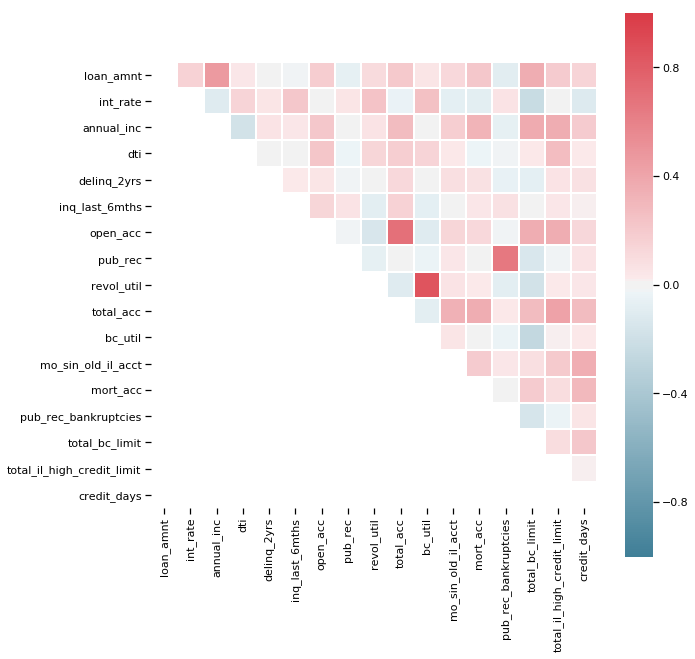

In [64]:
# correlation matrix of df_all
sns.set_context(context='notebook')
fig, ax = plt.subplots(figsize=(10,10)) 
corr = df_all.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.tril_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(225,10,sep=5, as_cmap=True)

sns.heatmap(corr, cmap=cmap,linewidths=1, vmin=-1, vmax=1, square=True, cbar=True, center=0, ax=ax, mask=mask)

plt.savefig('prj3_df_all_corr')

In [65]:
df_all.shape

(1357093, 26)

**I choose below 25 features for the loan default analysis**
* **loan_amnt**: The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value
* **term**: The number of payments on the loan. Values are in months and can be either 36 or 60
* **int_rate**: Interest Rate on the loan
* **grade**: LC assigned loan grade
* **annual_inc**: The self-reported annual income provided by the borrower during registration
* **verification_status**: Indicates if income was verified by LC, not verified, or if the income source was verified
* **purpose**: A category provided by the borrower for the loan request
* **dti**: A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income
* **delinq_2yrs**: The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years
* **inq_last_6mths**: The number of inquiries in past 6 months (excluding auto and mortgage inquiries)
* **open_acc**: The number of open credit lines in the borrower's credit file
* **pub_rec**: Number of derogatory public records
* **revol_util**: Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit
* **total_acc**: The total number of credit lines currently in the borrower's credit file
* **application_type**: Indicates whether the loan is an individual application or a joint application with two co-borrowers
* **bc_util**: Ratio of total current balance to high credit/credit limit for all bankcard accounts.
* **mo_sin_old_il_acct**: Months since oldest bank installment account opened
* **mort_acc**: Number of mortgage accounts
* **pub_rec_bankruptcies**: Number of public record bankruptcies
* **total_bc_limit**: Total bankcard high credit/credit limit
* **total_il_high_credit_limit**: Total installment high credit/credit limit
* **emp_years**: Employment length in years
* **home_ownership_type**: The home ownership status provided by the borrower during registration or obtained from the credit report. Values are: RENT, OWN, MORTGAGE, OTHER
* **region**: The region where borrower lives in
* **credit_days**: The days since the borrower's earliest reported credit line was opened

In [66]:
df_all.to_pickle('prj3_df_clean.pkl')

In [67]:
df = df_all.copy()

In [68]:
cols = [df.columns[-5]] + [col for col in df if col != df.columns[-5]]
df = df[cols]
df.head()

,loan_status_bin,loan_amnt,term,int_rate,grade,annual_inc,verification_status,purpose,dti,delinq_2yrs,...,bc_util,mo_sin_old_il_acct,mort_acc,pub_rec_bankruptcies,total_bc_limit,total_il_high_credit_limit,emp_years,home_ownership_type,region,credit_days
52,0,40000.0,60 months,16.14,C,45000.0,Verified,credit_card,50.53,0.0,...,67.3,114.0,1.0,0.0,45700.0,167965.0,1-5 years,MORTGAGE,MidWest,3632
98,0,20000.0,36 months,7.56,A,100000.0,Not Verified,credit_card,18.92,0.0,...,29.9,171.0,5.0,0.0,85100.0,74833.0,10+ years,MORTGAGE,West,7405
126,0,4500.0,36 months,11.31,B,38500.0,Not Verified,credit_card,4.64,0.0,...,28.9,180.0,0.0,0.0,15100.0,24595.0,10+ years,RENT,SouthWest,5641
147,0,30000.0,36 months,22.35,D,100000.0,Source Verified,debt_consolidation,30.46,0.0,...,46.9,83.0,1.0,1.0,28600.0,101984.0,1-5 years,MORTGAGE,West,2688
206,0,30000.0,36 months,15.02,C,90000.0,Verified,debt_consolidation,22.23,0.0,...,47.0,123.0,3.0,0.0,41600.0,36249.0,10+ years,RENT,MidWest,4394


## **Under Sampling**

In [69]:
# Class count
fully_paid_count, default_count = df.loan_status_bin.value_counts()
default_count

292279

In [70]:
# Divide by class
df_class_repaid = df[df['loan_status_bin'] == 0]
df_class_default = df[df['loan_status_bin'] == 1]
# random sampling
df_class_repaid_under = df_class_repaid.sample(default_count)
df_under = pd.concat([df_class_repaid_under, df_class_default], axis=0)

Random under-sampling:
1    292279
0    292279
Name: loan_status_bin, dtype: int64


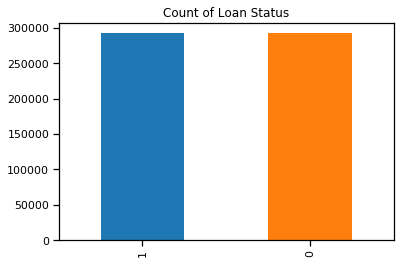

In [71]:
print('Random under-sampling:')
print(df_under.loan_status_bin.value_counts())

df_under.loan_status_bin.value_counts().plot(kind='bar', title='Count of Loan Status');

In [169]:
#df_under.to_csv('/Users/katiefan/Documents/prj3_df_under.csv')

## **Converting Categorical Features to Dummy Features**

In [72]:
# data encoding for categorical features
df_under['grade'] = df_under['grade'].map({'A':7,'B':6,'C':5,'D':4,'E':3,'F':2,'G':1})
df_under["home_ownership_type"] = df_under["home_ownership_type"].map({'OWN': 4,'MORTGAGE':3,'RENT':2,'OTHER':1})
df_under["emp_years"] = df_under["emp_years"].map({'5-10 years':3,'10+ years':2,'1-5 years':1})
df_under.head()

,loan_status_bin,loan_amnt,term,int_rate,grade,annual_inc,verification_status,purpose,dti,delinq_2yrs,...,bc_util,mo_sin_old_il_acct,mort_acc,pub_rec_bankruptcies,total_bc_limit,total_il_high_credit_limit,emp_years,home_ownership_type,region,credit_days
395144,0,4200.0,36 months,14.09,6,55000.0,Not Verified,debt_consolidation,25.99,0.0,...,96.9,113.0,5.0,0.0,4000.0,28305.0,1,3,West,7193
1480566,0,15000.0,36 months,14.42,4,110000.0,Verified,other,6.33,1.0,...,NaN,NaN,NaN,0.0,NaN,NaN,1,2,NorthEast,5671
1668394,0,15000.0,36 months,11.53,6,85000.0,Verified,credit_card,7.12,0.0,...,97.1,33.0,0.0,0.0,7500.0,12806.0,1,2,SouthEast,2719
353992,0,7500.0,36 months,10.16,6,85000.0,Not Verified,home_improvement,10.70,0.0,...,36.5,143.0,6.0,0.0,8800.0,43199.0,3,3,SouthEast,7193
1674395,0,24000.0,36 months,13.99,5,220000.0,Verified,credit_card,25.50,0.0,...,87.0,105.0,3.0,0.0,84800.0,105182.0,1,3,MidWest,11180


In [73]:
X = df_under.iloc[:, 1:]
y = df_under.iloc[:, 0]
y = y.astype('int')

In [74]:
X_dum = pd.get_dummies(X)
X_dum.head()

,loan_amnt,int_rate,grade,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_util,...,purpose_small_business,purpose_vacation,purpose_wedding,application_type_Individual,application_type_Joint App,region_MidWest,region_NorthEast,region_SouthEast,region_SouthWest,region_West
395144,4200.0,14.09,6,55000.0,25.99,0.0,0.0,11.0,0.0,90.2,...,0,0,0,1,0,0,0,0,0,1
1480566,15000.0,14.42,4,110000.0,6.33,1.0,2.0,15.0,0.0,20.3,...,0,0,0,1,0,0,1,0,0,0
1668394,15000.0,11.53,6,85000.0,7.12,0.0,0.0,7.0,0.0,69.6,...,0,0,0,1,0,0,0,1,0,0
353992,7500.0,10.16,6,85000.0,10.70,0.0,2.0,8.0,0.0,36.5,...,0,0,0,1,0,0,0,1,0,0
1674395,24000.0,13.99,5,220000.0,25.50,0.0,3.0,34.0,0.0,81.0,...,0,0,0,1,0,1,0,0,0,0


In [75]:
X_dum.to_pickle('prj3_X_dum.pkl')
y.to_pickle('prj3_y.pkl')

## **Training Test Sets Spliting**

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X_dum, y, test_size=0.2, random_state=42)

In [77]:
X_train.head()

,loan_amnt,int_rate,grade,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_util,...,purpose_small_business,purpose_vacation,purpose_wedding,application_type_Individual,application_type_Joint App,region_MidWest,region_NorthEast,region_SouthEast,region_SouthWest,region_West
957258,24000.0,12.99,5,75000.0,20.67,0.0,0.0,11.0,1.0,56.4,...,0,0,0,1,0,0,1,0,0,0
389568,24000.0,11.14,6,80000.0,18.68,0.0,1.0,16.0,0.0,79.9,...,0,0,0,1,0,1,0,0,0,0
1472038,1600.0,13.23,5,86000.0,13.40,0.0,1.0,6.0,0.0,85.0,...,0,0,0,1,0,0,0,0,0,1
431379,12800.0,12.12,6,75000.0,14.78,0.0,0.0,13.0,0.0,66.3,...,0,0,0,1,0,0,0,0,0,1
778234,20000.0,6.99,7,87400.0,18.55,0.0,0.0,18.0,0.0,22.3,...,0,0,0,1,0,1,0,0,0,0


## **Standard Scaling & Missing Value Imputing**

In [79]:
# Create an imputer object with a median filling strategy
imputer = Imputer(strategy='median')

# Train on the training features
imputer.fit(X_train)

# Transform both training and testing data
X_train = pd.DataFrame(imputer.transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

In [80]:
# Create an imputer object with a median filling strategy
scaler = StandardScaler()

# Train on the training features
scaler.fit(X_train)

# Transform both training and testing data
X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [81]:
X_train.to_pickle('prj3_X_train.pkl')
X_test.to_pickle('prj3_X_test.pkl')
y_train.to_pickle('prj3_y_train.pkl')
y_test.to_pickle('prj3_y_test.pkl')

### **Feature Selection using RFE (Recursive Feature Elimination)**

In [92]:
# # try logistic regression with RFE
# clf_LR = LogisticRegression()
# rfe = RFE(clf_LR, 10)
# res = rfe.fit(X_train, y_train)
# # summarize the selection of the attributes
# print(res.support_)
# print(res.ranking_)
# print(X_train.columns[res.support_])

[ True  True  True  True  True False False  True False False False False
 False  True False  True False False False False  True  True False False
 False False False False False False False False False False False False
 False False False False False False False False False False]
[ 1  1  1  1  1  6  4  1  8 22  2 29 28  1 17  1  7 12  5 11  1  1  3 21
 27 23 14 15 36 34 37 33 25 30 31 35 10 32 16 13 24 26 18 19 20  9]
Index(['loan_amnt', 'int_rate', 'grade', 'annual_inc', 'dti', 'open_acc',
       'mort_acc', 'total_bc_limit', 'term_ 36 months', 'term_ 60 months'],
      dtype='object')


In [93]:
# probs = rfe.predict_proba(X_test)
# predicted = rfe.predict(X_test)
# accuracy = accuracy_score(y_test, predicted)
# print('accuracy score:', accuracy)
# auc = metrics.roc_auc_score(y_test, probs[:, 1])
# print('AUC:', auc)

accuracy score: 0.6465290132749418
AUC: 0.7029006975591191


In [94]:
# # Logistic Regression with all features
# model1 = LogisticRegression()
# model1.fit(X_train, y_train)
# probs = model1.predict_proba(X_test)
# predicted = model1.predict(X_test)
# accuracy1 = accuracy_score(y_test, predicted)
# print('accuracy score:', accuracy1)
# auc1 = metrics.roc_auc_score(y_test, probs[:, 1])
# print('AUC:', auc1)

accuracy score: 0.6490351717531134
AUC: 0.7071856854736803


### **Feature Selection using PCA**

In [95]:
# # try PCA(Principal Component Analysis)

# pca = PCA(n_components=5, whiten=True)
# X_train_pca = pca.fit_transform(X_train)
# X_test_pca = pca.transform(X_test)
# explained_variance = pca.explained_variance_ratio_
# print('Expected Variance is '+ str(explained_variance))

Expected Variance is [0.0778043  0.06853041 0.04543362 0.04266128 0.04000653]
